# Rolling Planning mit Tardiness (Max)

In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check

import pandas as pd
pd.set_option('display.max_rows', 21)

import src.utils.rolling_scheduling as rolling_schedule

import src.models.lp.tardiness_solver as solver
from src.simulation.ProductionDaySimulation import ProductionDaySimulation
import time

In [2]:
max_time = 60*60*3 # 3h
max_time = 60*30   # 30 min

## Laden der Initialisierungsdaten

In [3]:
data_path = get_path("data", "lp_tardiness")

In [4]:
df_jssp = pd.read_csv(data_path / "02_tardiness_all_jssp.csv")
df_times = pd.read_csv(data_path / "02_tardiness_all_times.csv")

### Tag 0 

In [5]:
df_plan = pd.read_csv(data_path / "02_tardiness_init_plan.csv")
df_execution = pd.read_csv(data_path / "02_tardiness_execution.csv")
df_undone = pd.read_csv(data_path / "02_tardiness_init_undone.csv")

### Settings

In [6]:
def get_schedule_filename(prefix: str = "", day: int = 0, data_txt: str = "schedule", suffix: str = "") -> str:
    file_template = "{prefix}_{data}_{day:02d}{suffix}.csv"
    if suffix:
        suffix = f"_{suffix}"
    return data_path / file_template.format(prefix=prefix,data=data_txt,day=day, suffix=suffix)

## Params

In [7]:
# fix
day_length = 1440
horizon_days = 2

notebook_prefix = "3a"

#### Rescheduling für Tage 1-5
- Tag 1: Ankunfttermine in [1, 2] + unabgeschlosse von Vortagen (evtl. Tag 0)
- Tag 2: Ankunfttermine in [2, 3] + unabgeschlosse von Vortagen (evtl. Tag 0 "oder" Tag 1)
- ...
- Tag 5: Ankunfttermine in [5, 6] + unabgeschlosse von Vortagen

In [8]:
first_start = 1
last_planning_start = 5


Solver-Informationen:
  Maximale Tardiness      : 4634.25
  Solver-Status           : Optimal
  Anzahl Variablen        : 14921
  Anzahl Constraints      : 29249

  Scheduling-Dauer: 30 Minuten und 1.37 Sekunden.


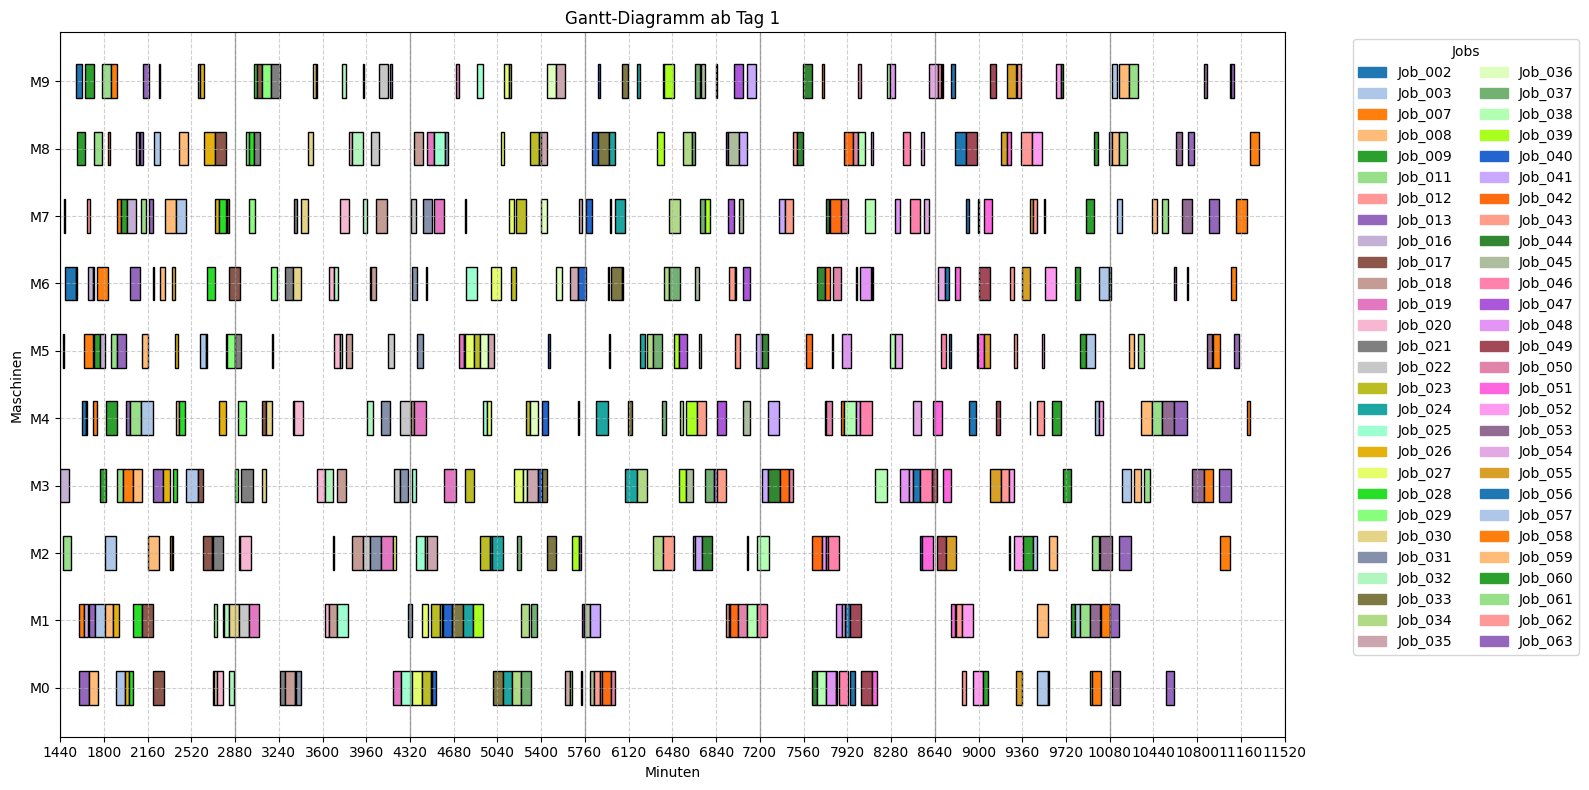

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

[24:00:00] Job_016 started on M3
[24:21:54] Job_002 started on M5
[24:26:35] Job_011 started on M2
[24:30:30] Job_002 finished on M5 (after 08 minutes 35 seconds)
[24:31:54] Job_002 started on M7
[24:50:45] Job_002 finished on M7 (after 18 minutes 51 seconds)
[24:50:45] Job_002 started on M6
[25:02:39] Job_016 finished on M3 (after 62 minutes 39 seconds)
[25:23:56] Job_011 finished on M2 (after 57 minutes 21 seconds)
[26:26:07] Job_002 finished on M6 (after 95 minutes 22 seconds)
[26:26:07] Job_009 started on M6
[26:26:07] Job_002 started on M9
[26:33:15] Job_007 started on M1
[26:33:15] Job_013 started on M0
[26:34:25] Job_009 finished on M6 (after 08 minutes 18 seconds)
[26:34:25] Job_009 started on M8
[26:54:33] Job_002 finished on M9 (aft

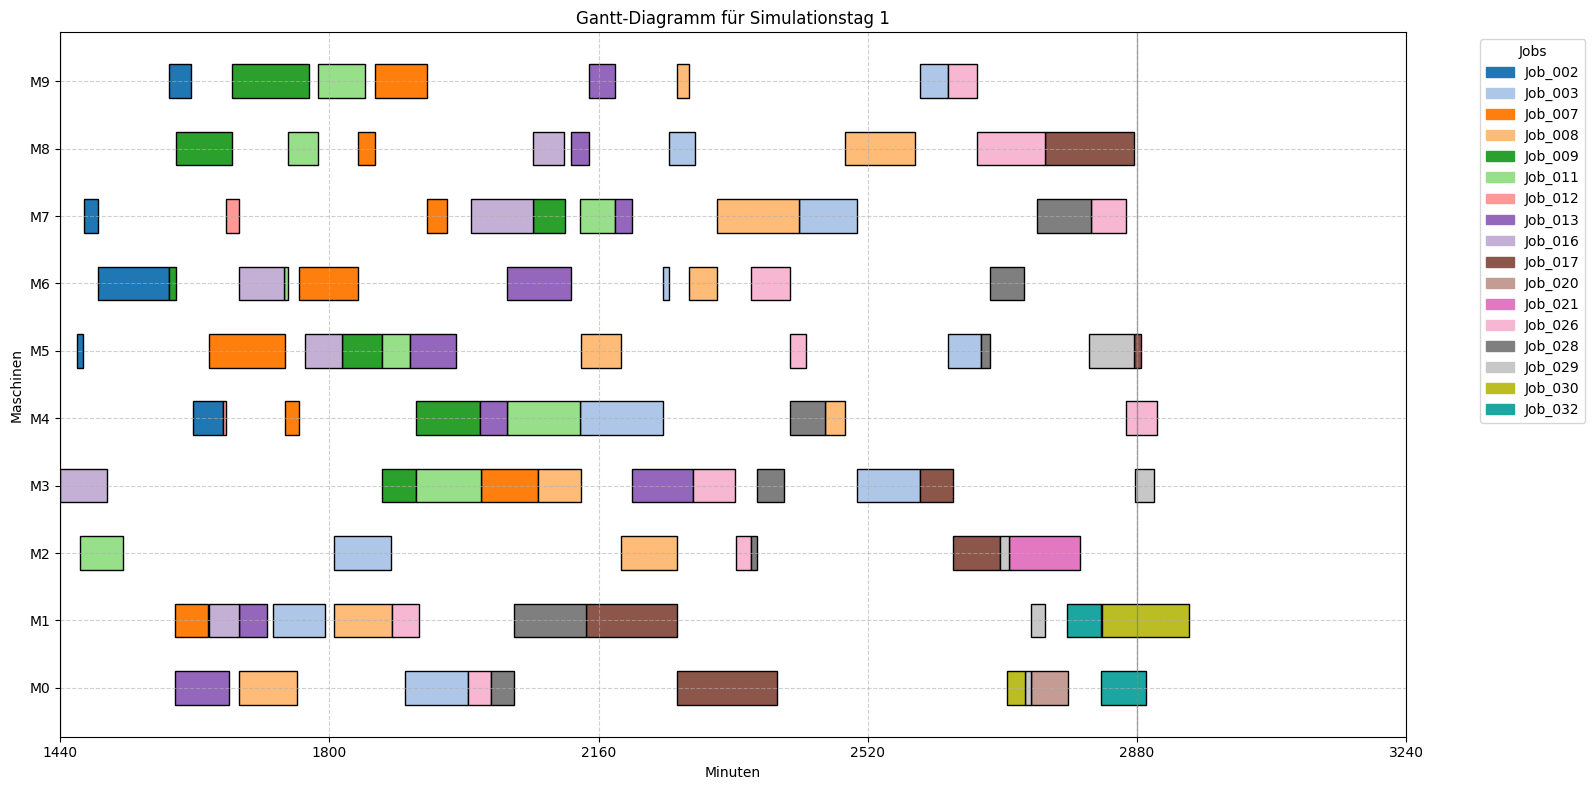


Solver-Informationen:
  Maximale Tardiness      : 5286.48
  Solver-Status           : Optimal
  Anzahl Variablen        : 27840
  Anzahl Constraints      : 54868

  Scheduling-Dauer: 30 Minuten und 6.92 Sekunden.


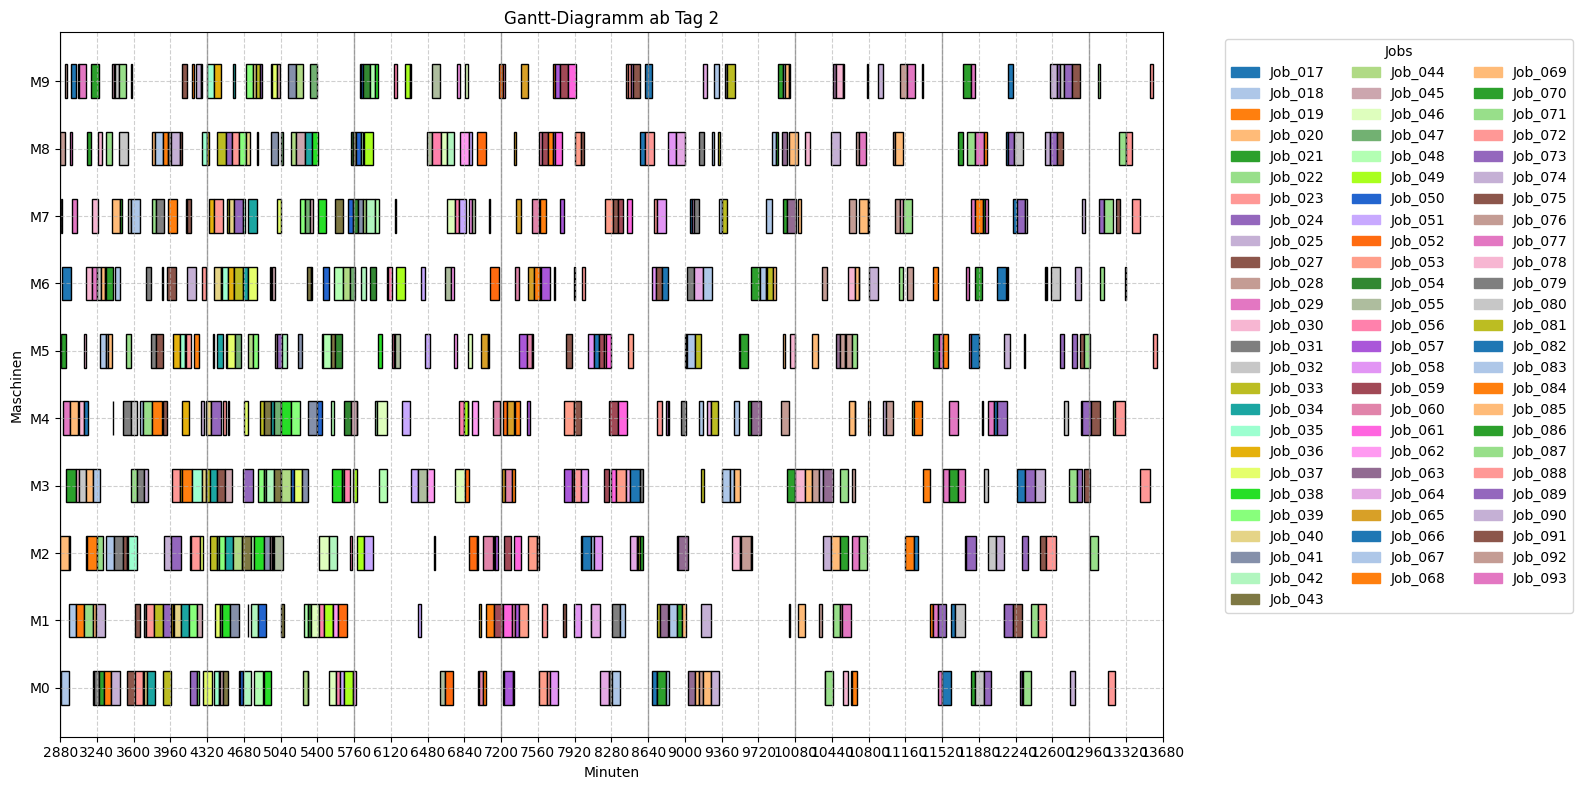

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

[48:00:00] Job_020 started on M2
[48:00:00] Job_028 started on M8
[48:05:28] Job_017 started on M7
[48:05:28] Job_021 started on M5
[48:11:52] Job_018 started on M0
[48:19:30] Job_017 finished on M7 (after 14 minutes 02 seconds)
[48:19:30] Job_017 started on M6
[48:26:46] Job_029 started on M4
[48:56:31] Job_021 finished on M5 (after 51 minutes 02 seconds)
[48:56:56] Job_028 finished on M8 (after 56 minutes 57 seconds)
[48:56:56] Job_028 started on M9
[48:57:28] Job_021 started on M3
[49:12:11] Job_028 finished on M9 (after 15 minutes 14 seconds)
[49:34:19] Job_029 finished on M4 (after 67 minutes 34 seconds)
[49:35:46] Job_029 started on M8
[49:36:47] Job_020 finished on M2 (after 96 minutes 47 seconds)
[49:36:47] Job_030 started on M2
[49:3

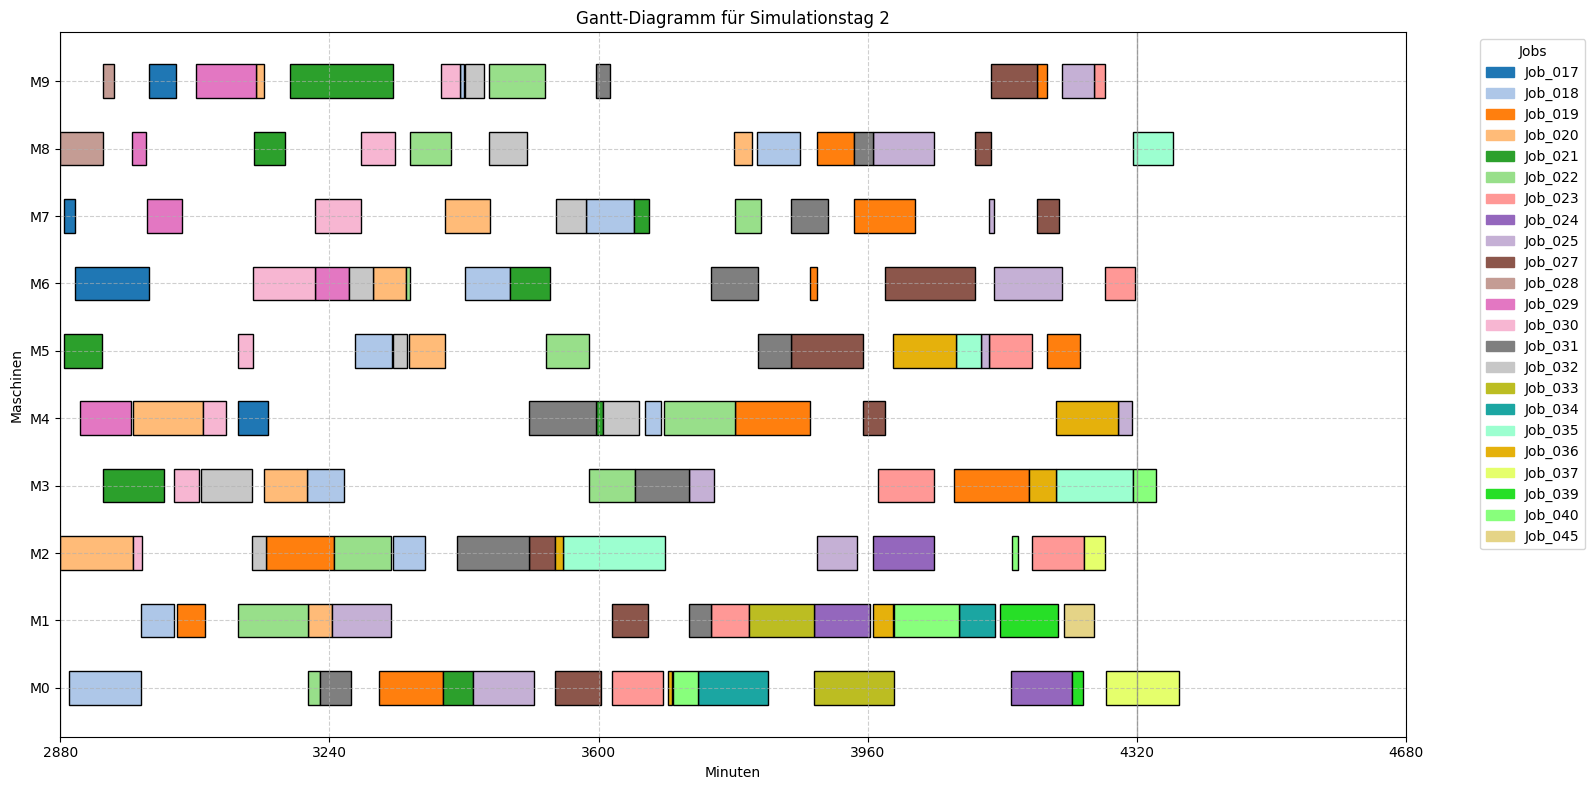

In [ ]:
for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length * day_numb
    day_end = day_start + day_length
    planning_end = day_start + horizon_days * day_length

    # ------------------- I. Ankunfts- und Operationsvorbereitung -------------------
    df_jssp_curr, df_times_curr = rolling_schedule.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, planning_end)
    df_jssp_curr = rolling_schedule.extend_with_undone_operations(df_jssp_curr, df_undone)
    df_times_curr = rolling_schedule.update_times_after_operation_changes(df_times, df_jssp_curr)

    # ------------------- II. Relevante laufende Operationen -------------------------
    df_execution_important = rolling_schedule.get_operations_running_into_day(df_execution, day_start)

    # ------------------- III. Rescheduling durchführen -------------------------------

    starting_time = time.time()
    df_plan = solver.solve_jssp_max_tardiness_with_fixed_ops(df_jssp_curr, df_times_curr, df_execution_important,
                                                           reschedule_start = day_start,
                                                           solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.02, threads=7)
    solver_duration = time.time() - starting_time
    print(f"\n  Scheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")

    df_plan.to_csv(get_schedule_filename(notebook_prefix, day=day_numb), index=False)

    show.plot_gantt_machines(df_plan, title=f"Gantt-Diagramm ab Tag {day_numb}")
    check.check_constraints(df_plan)

    # ------------------- IV. Einen Tag simulieren -------------------------------------

    simulation = ProductionDaySimulation(df_plan, vc=0.25)
    df_execution, df_undone = simulation.run(start_time=day_start, end_time=day_end)
    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}", duration_column="Simulated Processing Time")
    else:
        print(f"Nothing executed on day {day_numb}")